# Банки

У нас есть данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Наши главные задачи — анализ оттока клиентов, нахождение высокоотточных сегментов пользователей банка и создание рекомендаций по сокращению оттока.

В рамках исследования были проведены следующие этапы:
1. [Изучение данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Проверка статистических гипотез](#4)
5. [Сегментация отточных пользователей](#5)
6. [Выводы и рекомендации по стимулированию высокоотточных сегментов](#6)

<a id="1"></a>
## Изучение данных

**1.1** Для начала подгрузим все необходимые для работы бибилиотеки. 

In [1]:
!pip install phik -q

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statistics
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import scipy.stats as st
from scipy.stats import binom
import math as mth

**1.2** Теперь загрузим данные для исследования в переменную `banks`.

In [2]:
banks = pd.read_csv('datasets/bank_scrooge.csv')
banks.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


**1.3** Изучим общую информацию о таблице. 

In [3]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**1.4** Датасет состоит из 10 000 строк и 12 столбов:
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — приблизительная оценка собственности клиента,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта (1/0),
- `last_activity` — был ли клиент активен последнее время (1/0),
- `EST_SALARY` — оценочный доход клиента,
- `сhurn` — признак оттока (1/0).

**1.5** Посмотрим, по какой шкале оценивается собственность клиента. 

In [4]:
print('Минимальная оценка собственности клиента:', banks['equity'].min())
print('Максимальная оценка собственности клиента:', banks['equity'].max())

Минимальная оценка собственности клиента: 0
Максимальная оценка собственности клиента: 9


**1.6** Ценность собственности клиентов оценивается от 0 до 9 баллов.

Перейдём к предобработке данных. 

<a id="2"></a>
## Предобработка данных

**2.1** Для начала приведём названия столбцов `USERID` и `EST_SALARY` в предпочтительный вид. 

In [5]:
banks.rename(columns = {'USERID': 'user_id', 'EST_SALARY': 'est_salary'}, inplace=True)

**2.2** Теперь посмотрим на пропуски в таблице. 

In [6]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**2.3** В датасете есть пропуски в столбцах `age` и `balance`.

Возможно, пропуски в `balance` означают нулевой баланс. Проверим, есть ли в датасете клиенты с нулевым балансом. 

In [7]:
banks.query('balance < 1')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.33,0
6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23876.51,0


**2.4** В таблице есть клиенты с нулевым балансом, а значит, пропуски в `balance` могут означать не нулевой баланс, а отсутствие данных. Так как у нас нет уверенности в природе пропущенных значений и так как мы не можем удалить такое количество данных, оставим пропуски в таблице.

А вот строки с пропусками в столбце `age` можно удалить, так как они составляют менее 0.5% от всех данных. При этом заполнить пропуски средними или медианными значениями мы не можем. 

In [8]:
banks = banks.query('age > 0').reset_index(drop=True)

**2.5** Также посмотрим, есть ли у нас строки с нулевым количеством продуктов банка, так как клиентов без продуктов быть не может. 

In [9]:
banks.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8939,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


**2.6** Есть один пользователь без банковских продуктов. Удалим эту строку из датасета. 

In [11]:
banks = banks.query('products > 0').reset_index(drop=True)
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   float64
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 935.1+ KB


**2.7** И посмотрим на минимальный возраст клиентов банка. 

In [13]:
print(banks['age'].min())

18.0


**2.8** Всё верно: клиентами банка могут стать только совершеннолетние.

Теперь посмотрим на типы данных:
- Столбцы `user_id`, `equity`, `products`, `credit_card`, `last_activity` и `churn` выражены типом `int`. Это верный тип данных, так как данные во всех этих столбцах должны иметь целочисленные значения (в том числе двоичные обозначения).
- Столбцы `city` и `gender` верно представлены типом `object`.
- Столбцы `balance` и `est_salary` представлены типом `float`, так как денежные меры могут принимать десятичные значения. 

Стоит обратить внимание на столбцы `score` и `age`. Возраст может выражаться только в целых числах, и так как мы удалили пропуски в этом столбце, можно привести его данные к типу `int`. Также проверим столбец `score`: какие значения в нём представлены.


In [14]:
banks['score'].unique()

array([ 850.,  861.,  892.,  866.,  730.,  856.,  807.,  825.,  923.,
        906.,  927.,  921.,  845.,  837.,  815.,  731.,  829.,  793.,
        876.,  922.,  772.,  896.,  871.,  732.,  898.,  806.,  766.,
        776.,  868.,  946.,  828.,  786.,  944.,  863.,  822.,  794.,
        924.,  811.,  814.,  956.,  935.,  826.,  849.,  901.,  893.,
        792.,  888.,  831.,  748.,  820.,  860.,  914.,  930.,  948.,
        789.,  737.,  812.,  933.,  809.,  749.,  873.,  859.,  950.,
        937.,  835.,  768.,  767.,  785.,  846.,  750.,  816.,  894.,
        891.,  788.,  758.,  787.,  821.,  855.,  779.,  791.,  838.,
        971.,  797.,  841.,  915.,  985.,  870.,  897.,  763.,  774.,
        686., 1000.,  875.,  819.,  869.,  854.,  810.,  761.,  802.,
        958.,  917.,  745.,  736.,  908.,  928.,  884.,  853.,  780.,
        726.,  881.,  975.,  852.,  965.,  899.,  890.,  836.,  818.,
        880.,  795.,  916.,  775.,  902.,  918.,  842.,  771.,  895.,
        801.,  721.,

**2.9** В столбце `score` представлены только целые числа. Следовательно, его мы тоже можем привести к типу `int`.

In [15]:
banks['score'] = banks['score'].astype('int')
banks['age'] = banks['age'].astype('int')
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   int64  
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   int64  
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 935.1+ KB


**2.10** Проверим данные на наличие явных дубликатов.


In [17]:
print(banks.duplicated().sum())

0


**2.11** Явных дубликатов нет. 

Проверим, все ли id пользователей в таблице уникальны.

In [18]:
banks['user_id'].nunique()

9923

**2.12** В таблице явно есть повторяющиеся id пользователей, так как среди 9973 строк насчитывается только 9923 уникальных пользователей (50 дублей).

Посмотрим на строки с повторами в `user_id`.

In [19]:
banks_duplicated = banks[banks.duplicated(subset=['user_id'])]

list_duplicated = banks_duplicated['user_id'].tolist()

banks_not_unique = banks.query('user_id == @list_duplicated').sort_values(by='user_id')
banks_not_unique


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1892,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1
7683,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0
7531,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0
4862,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1
5856,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1739,220816,840,Ярославль,Ж,41,3,1193287.13,2,1,1,76434.94,1
4212,226719,903,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0
2594,226719,990,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1
8192,227795,840,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1


**2.13** Итак, мы нашли 100 строк с повторами в `user_id`. Однако мы видим, что одинаковым id соответствуют абсолютно разные данные, в том числе различаются города. Возможно, базы филиалов объединили не сразу, из-за чего были присвоены одинаковые id в разных отделениях банка.

Проверим, есть ли совпадения по паре `user_id`-`city`.

In [20]:
len(banks_not_unique.groupby(['user_id', 'city'], as_index=False))

100

**2.14** Всего 100 уникальных пар, что соответствует количеству строк полученного среза. Следовательно, все совпадающие id привязаны к разным городам и пользователям. Можно сказать, что неявных дубликатов в таблице нет. 

**Промежуточные выводы:**

В рамках изучения и предобработки данных была проведена следующая работа:
1. Изучено, что датасет состоит из 10 000 строк и 12 столбов.
2. Все названия столбцов приведены в предпочтительный вид.
3. Убраны строки с пропусками в столбце `age` (26 строк), также было решено оставить пропуски в столбце `balance`.
4. Проверено наличие явных и неявных дубликатов: не найдены. 
5. Данные столбцов приведены к нужному типу.  

<a id="3"></a>
## Исследовательский анализ данных

**3.1** Для начала узнаем общую долю оттока среди клиентов банка. 

In [21]:
churn_share = banks['churn'].mean()

print('Общее количество отточных пользователей:', banks['churn'].sum())
print(f'Общая доля отточных пользователей: {churn_share:.1%}')

Общее количество отточных пользователей: 1818
Общая доля отточных пользователей: 18.2%


**3.2** Итак, 18.2% пользователей уходят из банка в последнее время, что является достаточно большой долей. Теперь сравним усреднённые портреты постоянного клиента и клиента, который перестал пользоваться услугами банка. 

Выведем исходную таблицу.

In [22]:
banks.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


**3.3** Возьмём все столбцы с численными показателями и найдём медиану этих показателей в разрезе по параметру оттока. Медиана позволит проигнорировать выбросы (если таковые имеются) в численных столбцах. Также медиана, применяемая к столбцам с булевым значением (1/0), выведет более популярный результат (тот, который пересекает 50%).  

In [23]:
pivot_banks_num = banks[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary','churn']]\
                  .pivot_table(index='churn', aggfunc='median')
pivot_banks_num

,age,balance,credit_card,equity,est_salary,last_activity,products,score
churn,,,,,,,,
0,40.0,475410.09,1.0,3.0,118227.60,0.0,2.0,848.0
1,39.0,783908.90,1.0,4.0,125408.88,1.0,2.0,866.0


**3.4** Теперь найдём моду для столбцов с полом и городом. 

In [24]:
pivot_banks_cat = banks[['city', 'gender', 'churn']].pivot_table(index='churn', aggfunc=statistics.mode)
pivot_banks_cat

,city,gender
churn,,
0,Ярославль,Ж
1,Ярославль,М


**3.5** Объединим две таблицы в одну и транспонируем её для лучшего восприятия.

In [25]:
client_portrait = pd.merge(pivot_banks_num, pivot_banks_cat, left_index=True, right_index=True, how='outer')
client_portrait = client_portrait.T
client_portrait.columns = ['Действующие клиенты', 'Отточные клиенты']
client_portrait

,Действующие клиенты,Отточные клиенты
age,40.0,39.0
balance,475410.09,783908.9
credit_card,1.0,1.0
equity,3.0,4.0
est_salary,118227.6,125408.88
last_activity,0.0,1.0
products,2.0,2.0
score,848.0,866.0
city,Ярославль,Ярославль
gender,Ж,М


**3.6** Итак: 
- медианный возраст действующих и отточных клиентов приблизительно одинаковый (40-39 лет);
- отточные клиенты до ухода в основном имели больший баланс на счёте: в среднем 783 000 по сравнению с 475 000 у действующих клиентов;
- большая часть всех клиентов имеет кредитную карту, проживает в Ярославле и в среднем имеет всего 2 продукта;
- отточные клиенты в среднем имеют более высокий балл собственности: 4 против 3;
- заработная плата и баллы кредитного скоринга у действующих и отточных клиентов приблизительно одинаковые (у отточных эти показатели чуть выше);
- среди отточных клиентов бОльшая доля — это активные клиенты, а среди действующих клиентов — пассивные. 

Таким образом, **среднестатистический отточный клиент — это мужчина средних лет из Ярославля. Он имеет около 780 000 рублей на счету, получает более высокий доход и обладает бОльшим количеством собственности по сравнению с лояльными клиентами. У него более высокий уровень кредитного скоринга, он активный и имеет кредитную карту**.

Такие клиенты кажутся более привлекательными, нежели клиенты, которые остались в банке. Поэтому надо выявить более точные сегменты отточных пользователей и разработать меры по их удержанию. 

**3.7** Построим нормализованные гистограммы по каждому парметру и выделим интервалы, где плотность вероятности у отточных пользователей выше. 

Начнём с возраста.

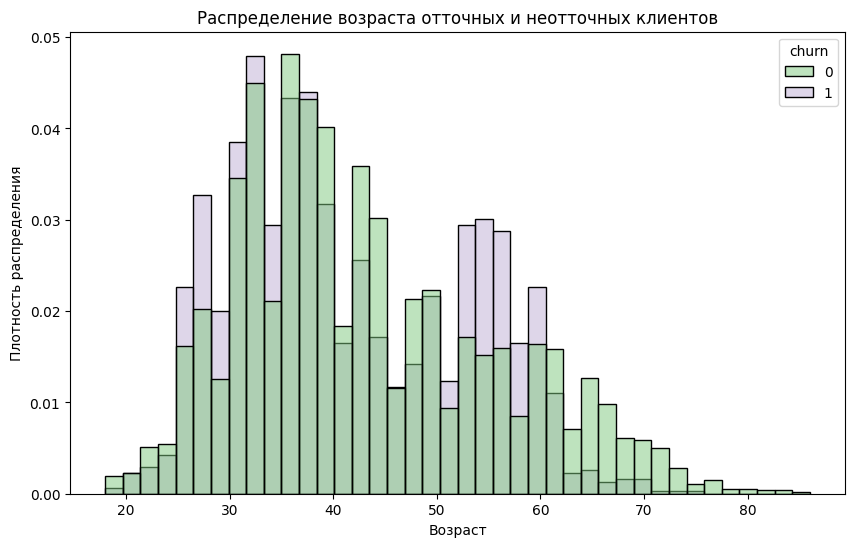

In [41]:
plt.figure(figsize=(10, 6))
sns.set_palette('Accent')

sns.histplot(data=banks, bins=40, hue='churn', x='age', stat='density', common_norm=False)

plt.title('Распределение возраста отточных и неотточных клиентов')
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.show()

**3.8** Зелёным цветом закрашены те столбцы, где действующие клиенты превалируют над отточными. Серым цветом выделяются те показатели, где отточных клиентов больше. Таким образом мы можем выделить два высокоотточных интервала по возрасту:
- с 25 до 35 лет.
- с 50 до 61 года.

**3.9** Теперь посмотрим на распределение баланса.

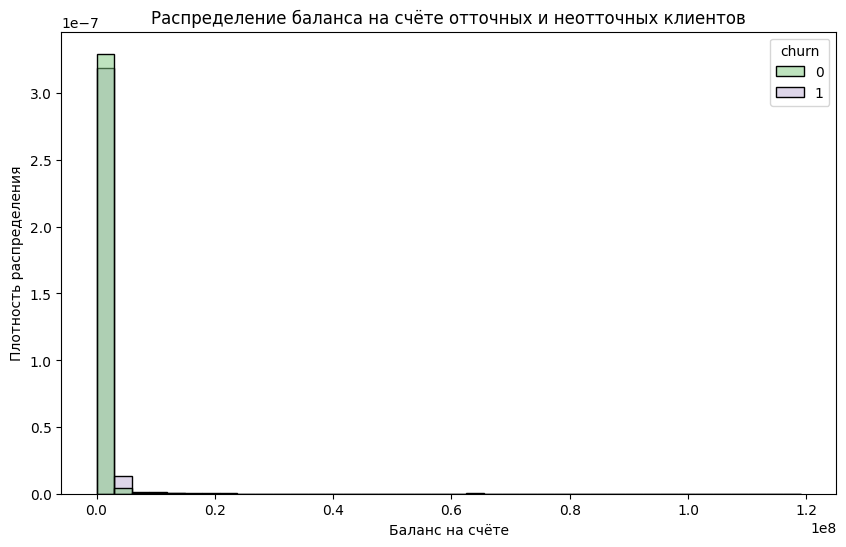

In [42]:
plt.figure(figsize=(10, 6))
sns.set_palette('Accent', desat=1)

sns.histplot(data=banks, bins=40, hue='churn', x='balance', stat='density', common_norm=False)

plt.title('Распределение баланса на счёте отточных и неотточных клиентов')
plt.xlabel('Баланс на счёте')
plt.ylabel('Плотность распределения')

plt.show()

**3.10** В данных явно есть выбросы, из-за чего график становится нечитабельным. Ограничим график по оси X. Чтобы понять, насколько ограничивать, сначала посмотрим статистические характеристики столбца `balance`.

In [28]:
pd.options.display.float_format ='{:,.2f}'.format
banks['balance'].describe()

count         7,695.00
mean        827,245.59
std       1,980,327.41
min               0.00
25%         295,698.71
50%         524,295.33
75%         980,051.21
max     119,113,552.01
Name: balance, dtype: float64

**3.11** Мы видим, что 75% клиентов имеют на счёте до 980 000 рублей. Выбросы же достигают суммы в 119 млн. Возможно, эти данные достоверны, поэтому мы не будем исключать их из датасета. Однако ограничим значения баланса для графика 95-м перцентилем. 

In [29]:
balance_banks = banks.query('balance >= 0')
balance_95_perc = np.percentile(balance_banks['balance'], 95)

balance_hist = banks.query('balance <= @balance_95_perc')

**3.12** Теперь построим гистограмму. 

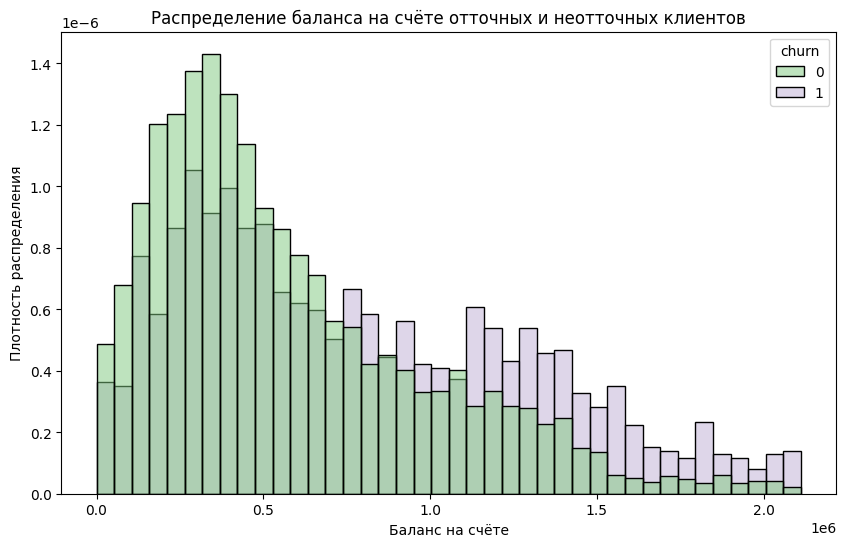

In [43]:
plt.figure(figsize=(10, 6))
sns.set_palette('Accent', desat=1)

sns.histplot(data=balance_hist, bins=40, hue='churn', x='balance', stat='density', common_norm=False)

plt.title('Распределение баланса на счёте отточных и неотточных клиентов')
plt.xlabel('Баланс на счёте')
plt.ylabel('Плотность распределения')

plt.show()

**3.13** На графике явно видна зависимость между доходом и оттоком: чем выше доход, тем больше отточных клиентов. 
- отточными становятся те клиенты, баланс на счёте которых превышает 700 тысяч. 
- самыми высокоотточными являются пользователи, которые имеют на счёте более 1 100 000. 

**3.14** Теперь посмотрим на показатель наличия кредитной карты. 

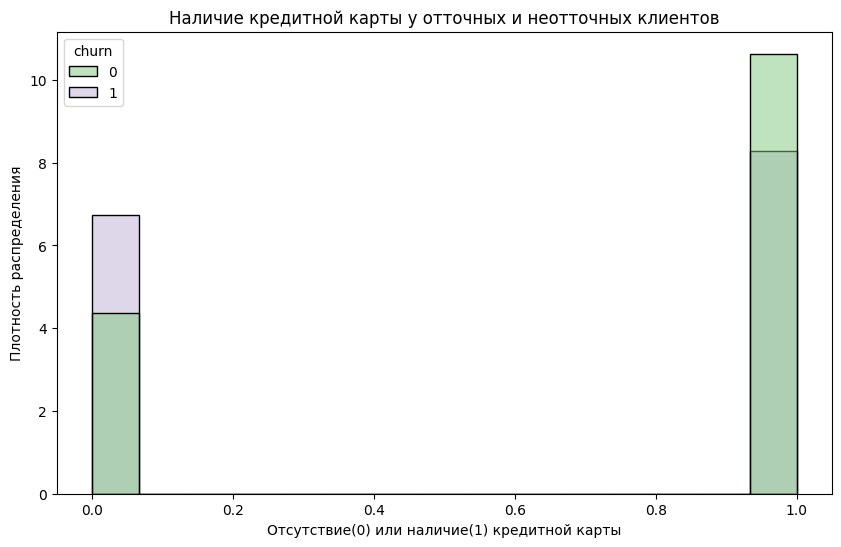

In [31]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, hue='churn', x='credit_card', stat='density', common_norm=False)

plt.title('Наличие кредитной карты у отточных и неотточных клиентов')
plt.xlabel('Отсутствие(0) или наличие(1) кредитной карты')
plt.ylabel('Плотность распределения')
plt.show()

**3.15** На графике явно видно **большое количество отточных клиентов среди тех, у кого не было кредитной карты**. Возможно, кредитная карта является одним из факторов удержания клиента. 

Посмотрим на столбец `equity`.

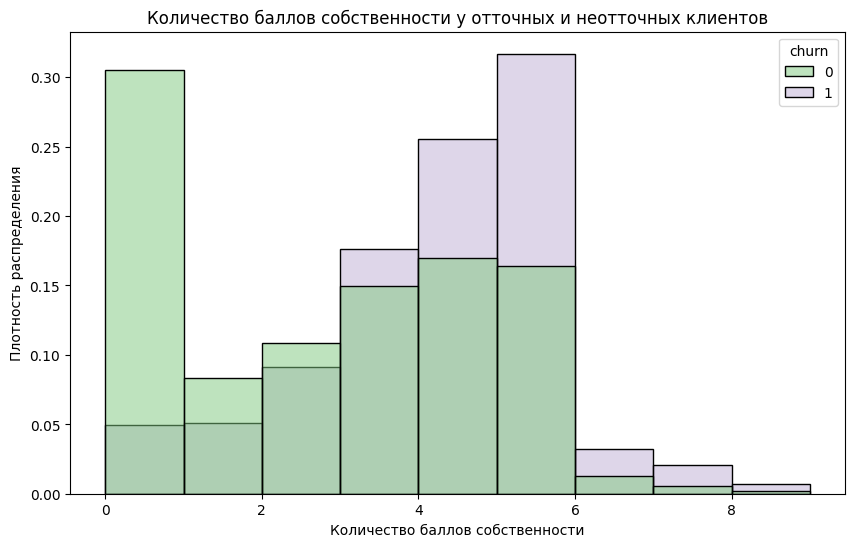

In [44]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, bins=9, hue='churn', x='equity', stat='density', common_norm=False)

plt.title('Количество баллов собственности у отточных и неотточных клиентов')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Плотность распределения')
plt.show()

**3.16** Мы видим, что лояльные клиенты превалируют среди тех людей, у которых баллы собственности варьируются от 0 до 2. В остальных случаях доля отточных клиентов выше. Таким образом, высокоотточный сегмент:
- клиенты, чьи баллы собственности находятся в диапазоне от 3 до 9. 

Посмотрим на распределение оценочного дохода клиента. 

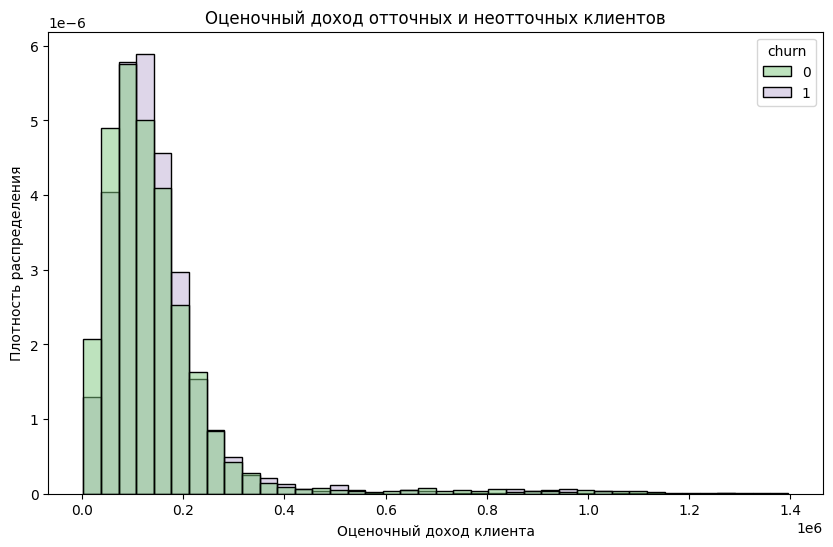

In [45]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, bins=40, hue='churn', x='est_salary', stat='density', common_norm=False)

plt.title('Оценочный доход отточных и неотточных клиентов')
plt.xlabel('Оценочный доход клиента')
plt.ylabel('Плотность распределения')
plt.show()

**3.17** Так же, как и с балансом, мы видим, что в данных присутствуют выбросы. Однако, мы не можем быть уверены, что доход в 1 400 000 недостоверный. Поэтому мы не будем убирать выбросы из датасета, а просто ограничим данные для графика 95-м перцентилем. 

In [34]:
est_salary_95_perc = np.percentile(banks['est_salary'], 95)

est_salary_hist = banks.query('est_salary <= @est_salary_95_perc')

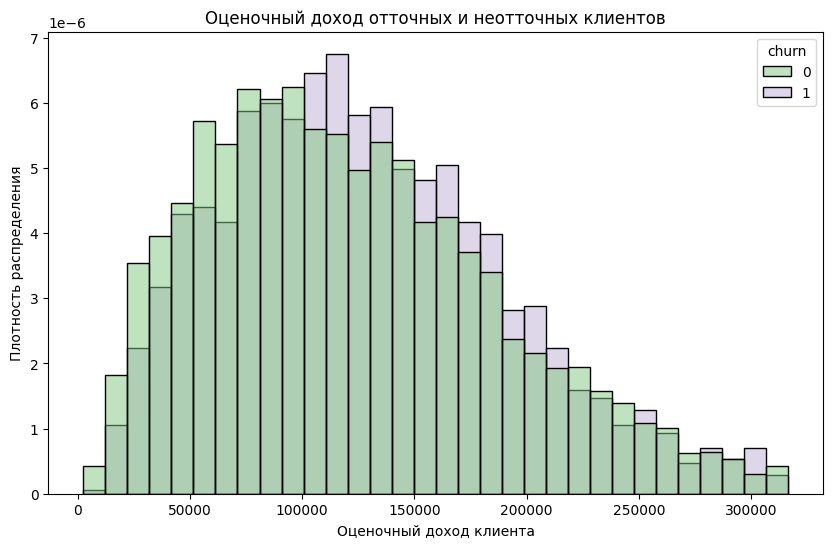

In [46]:
plt.figure(figsize=(10, 6))

sns.histplot(data=est_salary_hist, bins=32, hue='churn', x='est_salary', stat='density', common_norm=False)

plt.title('Оценочный доход отточных и неотточных клиентов')
plt.xlabel('Оценочный доход клиента')
plt.ylabel('Плотность распределения')
plt.show()

**3.18** Здесь можно выделить два высокоотточных сегмента:
- с зарплатой от 100 000 до 140 000 рублей. 
- с зарплатой от 150 000 до 220 000. 

Посмотрим на столбец `last_activity`.

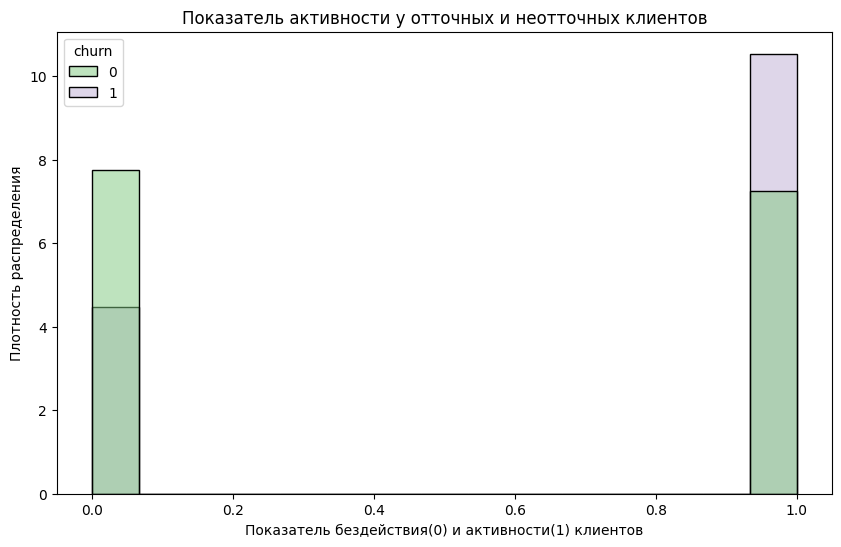

In [36]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, hue='churn', x='last_activity', stat='density', common_norm=False)

plt.title('Показатель активности у отточных и неотточных клиентов')
plt.xlabel('Показатель бездействия(0) и активности(1) клиентов')
plt.ylabel('Плотность распределения')
plt.show()

**3.19** Гистограмма подтвердила вывод, полученный при рассмотрении общих портретов отточных и неотточных клиентов: отточные клиенты были более активными. Возможно, им, как активным пользователям, не хватало бонусов, комформтных условий и спец. предложений от банка. В то время как многие действующие пользователи не проявляют активность и не интересуются возможностями банка. 

Посмотрим на распределение количества продуктов, которыми пользуются клиенты. 

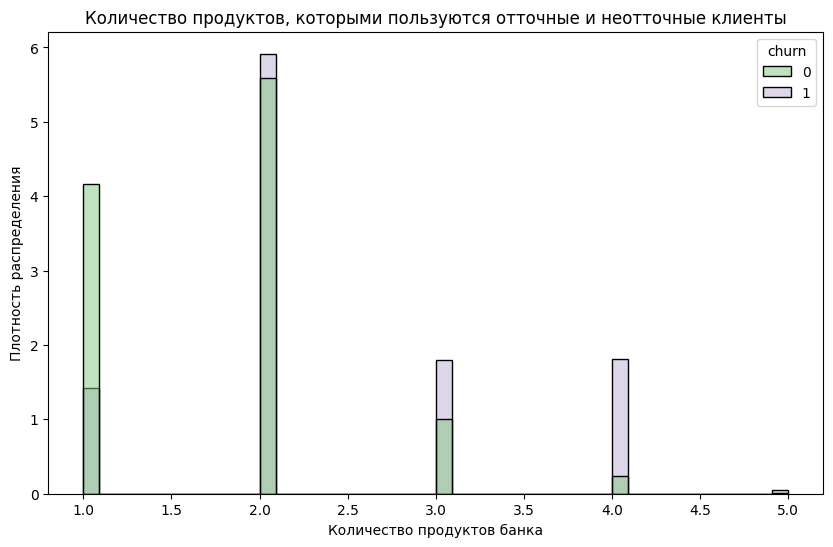

In [47]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, hue='churn', x='products', stat='density', common_norm=False)

plt.title('Количество продуктов, которыми пользуются отточные и неотточные клиенты')
plt.xlabel('Количество продуктов банка')
plt.ylabel('Плотность распределения')
plt.show()

**3.20** Действующие клиенты в основном имеют 1-2 продукта. При этом среди тех пользователей, что имеют от 2 продуктов и выше, больше отточных клиентов. Таким образом, отточный сегмент:
- клиенты, имеющие от 2 до 5 продуктов банка. 

Теперь рассмотрим распределение баллов кредитного скоринга.

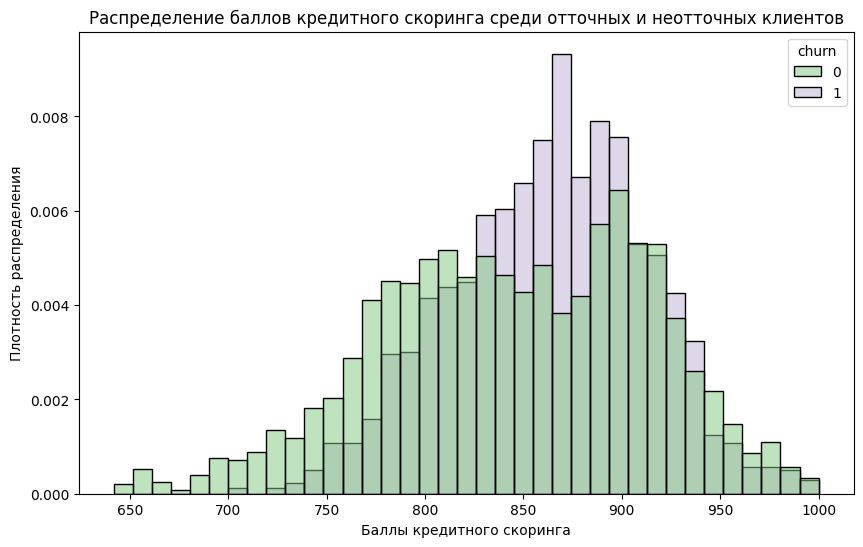

In [49]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, bins=37, hue='churn', x='score', stat='density', common_norm=False)

plt.title('Распределение баллов кредитного скоринга среди отточных и неотточных клиентов')
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Плотность распределения')
plt.show()

**3.21** На графике явно выделяется один высокоотточный сегмент:
- клиенты, с баллами кредитного скоринга примерно от 830 до 905.

Посмотрим на распределение отточных и неотточных клиентов по городам. 

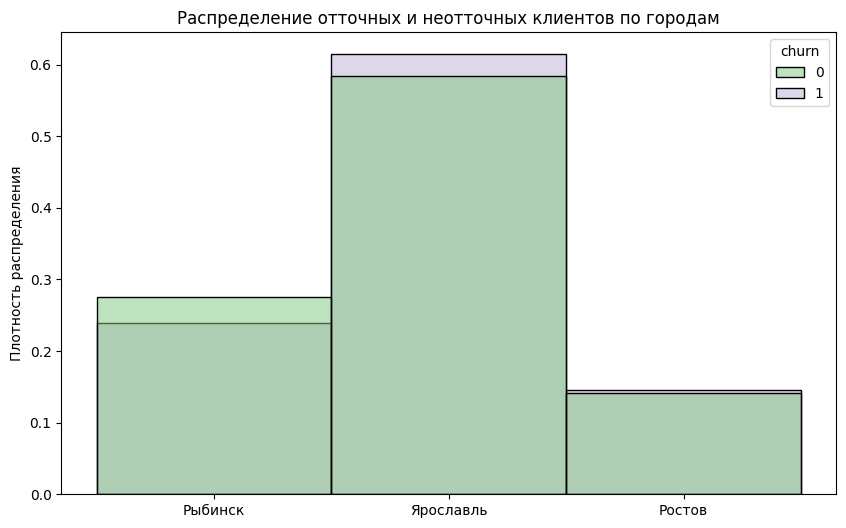

In [50]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, hue='churn', x='city', stat='density', common_norm=False)

plt.title('Распределение отточных и неотточных клиентов по городам')
plt.xlabel(None)
plt.ylabel('Плотность распределения')
plt.show()

**3.22** Жители Ярославля чаще становятся отточными клиентами. Также отточные клиенты выделяются в Ростове, но незначительно. 

Посмотрим на пол среди отточных и неотточных клиентов. 

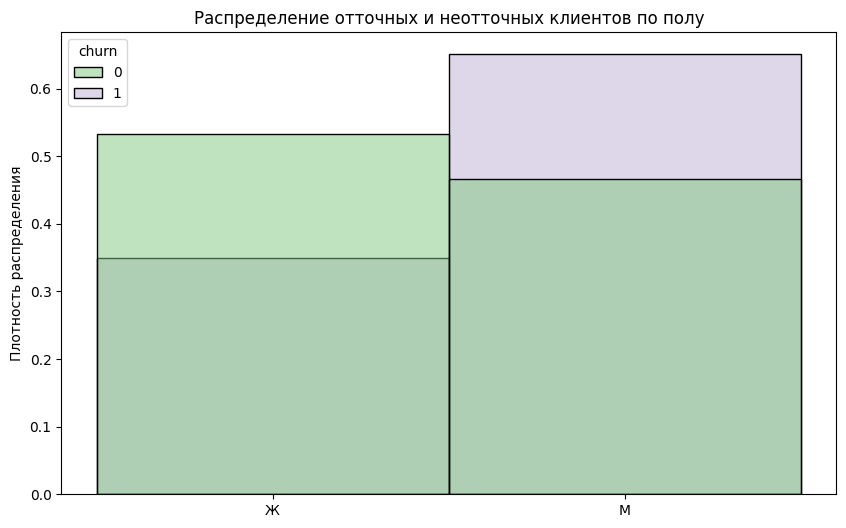

In [51]:
plt.figure(figsize=(10, 6))

sns.histplot(data=banks, hue='churn', x='gender', stat='density', common_norm=False)

plt.title('Распределение отточных и неотточных клиентов по полу')
plt.xlabel(None)
plt.ylabel('Плотность распределения')
plt.show()

**3.23** Как и было видно из сводной таблицы: **больше отточных клиентов среди мужчин**. Женщины обычно остаются действующими клиентами банка. 

**3.24** Теперь посмотрим корреляцию признаков. Так как у нас в таблице присутствуют категориальные данные, применим для корреляции метод `phik`. 

Предварительно удалим столбец `user_id`, так как он не несёт никакой информации для подсчёта корреляции. 

In [52]:
banks_for_corr = banks.drop('user_id', axis=1)

banks_phik = banks_for_corr.phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary'], 
                  bins={'score':15, 'age':15, 'balance':15, 'est_salary':15})
banks_phik

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.00,0.12,0.06,0.05,0.46,0.28,0.42,0.17,0.04,0.41,0.19
city,0.12,1.00,0.01,0.13,0.06,0.03,0.13,0.07,0.03,0.23,0.02
gender,0.06,0.01,1.00,0.25,0.06,0.03,0.07,0.20,0.01,0.12,0.22
age,0.05,0.13,0.25,1.00,0.04,0.00,0.14,0.14,0.07,0.40,0.16
equity,0.46,0.06,0.06,0.04,1.00,0.00,0.58,0.22,0.05,0.25,0.35
balance,0.28,0.03,0.03,0.00,0.00,1.00,0.00,0.01,0.01,0.57,0.03
products,0.42,0.13,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26
credit_card,0.17,0.07,0.20,0.14,0.22,0.01,0.27,1.00,0.05,0.04,0.20
last_activity,0.04,0.03,0.01,0.07,0.05,0.01,0.11,0.05,1.00,0.04,0.26
est_salary,0.41,0.23,0.12,0.40,0.25,0.57,0.22,0.04,0.04,1.00,0.06


**3.25** Построим тепловую карту с этой матрицей для лучшей визуализации.  

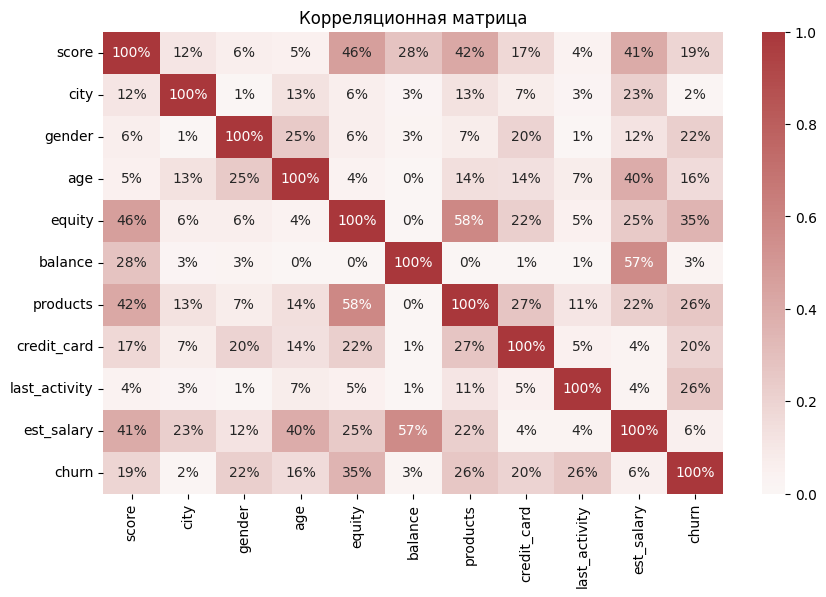

In [53]:
plt.figure(figsize=(10, 6))

sns.heatmap(banks_phik, annot=True, fmt='.0%', cmap='vlag', center=0)
plt.title('Корреляционная матрица')
plt.show()

**3.27** Итак, мы видим, что сильных корелляционных зависимостей между признаками мало. Отметим основные:
- Баллы кредитного скоринга (`score`) имеют зависимость более 40% с количеством баллов собственности (`equity`), количеством взятых продуктов банка (`products`) и оценочным доходом клиентов (`est_salary`). Видимо, это основные показатели, формирующие кредитное доверие. 
- Корреляционная матрица показывает зависимость в 58% между количеством баллов собственности (`equity`) и количеством продуктов, которыми пользуется клиент (`products`). Возможно, чем больше собственности, тем больше услуг банка требуется (страховка жилья, автомобиля и т. п.)
- Также есть корреляция в 57% между балансом на счёте (`balance`) и оценочным доходом клиента (`est_salary`), что выглядит логичным. 
- Оценочный доход клиента, в свою очередь, коррелирует с баллами кредитного скоринга (`score`), возрастом (`age`) и балансом на счёте (`balance`): 41%, 40% и 57% соответственно. 

Остальные корреляции не такие значительные и составляют менее 40%. 

Так как для нашего исследования важен показатель оттока клиентов, посмотрим корреляцию отдельно по столбцу `churn`.

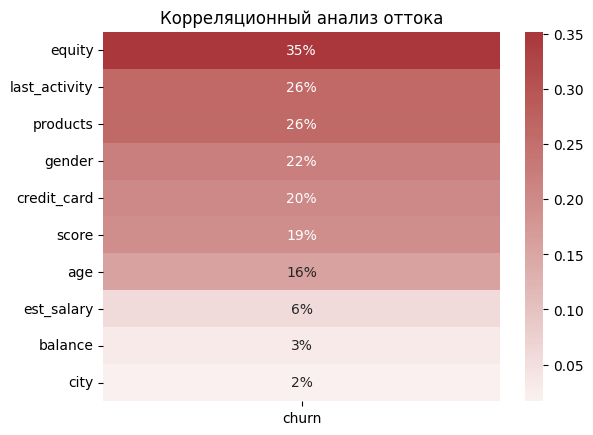

In [54]:
sns.heatmap(banks_phik.loc[:,['churn']].drop('churn').sort_values('churn', ascending=False), 
            annot=True, fmt='.0%', cmap='vlag', center=0)

plt.title('Корреляционный анализ оттока')
plt.show()

**3.28** Самый большой процент корреляции (35%) между показателем оттока и количеством баллов собственности. Следовательно, чем больше у клиента баллов собственности, тем выше шанс, что он уйдёт из нашего банка.
По 26% корреляции у `last_activity` и `products`, 22% у `gender` и 20% у `credit_card`. 

Стоит отметить, что в целом процент корреляции между показателем оттока и другими параметрами невысокий. 

**Промежуточные выводы:** 
1. В рамках исследовательского анализа было определено, что общая доля отточных пользователей: 18.2% (1 818 клиентов).

2. Были получены общие характеристики отточных и неотточных пользователей:
- медианный возраст действующих и отточных клиентов приблизительно одинаковый (39-40 лет);
- отточные клиенты до ухода в основном имели больший баланс на счёте: в среднем 783 000 по сравнению с 475 000 у действующих клиентов;
- большая часть всех клиентов имеет кредитную карту, проживает в Ярославле и в среднем имеет всего 2 банковских продукта;
- отточные клиенты в среднем имеют более высокий балл собственности: 4 против 3;
- заработная плата и баллы кредитного скоринга у действующих и отточных клиентов приблизительно одинаковые (у отточных эти показатели чуть выше);
- среди отточных клиентов бОльшая доля — это активные клиенты, а среди действующих клиентов — пассивные.

3. Также в рамках анализа общих характеристик было выдвинуто предположение, что отточные клиенты более привлекательны для бизнеса, нежели клиенты, которые остались в банке.

4. При построении нормализованных гистограмм были выявлены высокоотточные сегменты:
- возраст с 25 до 35 лет и с 50 до 61 года;
- баланс на счёте свыше 700 тысяч (самыми высокоотточными являются пользователи, которые имеют на счёте более 1 100 000);
- отсутствие кредитной карты;
- клиенты, чьи баллы собственности находятся в диапазоне от 3 до 9;
- зарплата (доход) от 100 000 до 140 000 рублей и от 150 000 до 220 000;
- активные пользователи;
- клиенты, имеющие от 2 до 5 продуктов банка;
- клиенты с баллами кредитного скоринга примерно от 830 до 905;
- жители Ярославля (в меньше степени Ростова);
- мужчины.

5. При корреляционном анализе относительно показателя оттока были получены следующие выводы:
- самый большой процент корреляции (35%) между показателем оттока и количеством баллов собственности (`equity`);
- по 26% корреляции у `last_activity` и `products`, 22% у `gender` и 20% у `credit_card`;
- в целом процент корреляции между показателем оттока и другими параметрами невысокий.


<a id="4"></a>
## Проверка статистических гипотез

**4.1** Проверим гипотезу о равенстве дохода между теми клиентами, которые ушли, и теми, которые остались. Для начала сформулируем нулевую и альтернативную гипотезы.

**Нулевая гипотеза:** Средний доход клиентов, которые ушли из банка, равен среднему доходу клиентов, которые остались в банке. 

**Альтернативная гипотеза:**  Средний доход клиентов, которые ушли из банка, не равен среднему доходу клиентов, которые остались в банке.

Для начала вспомним, что в датасете есть большие выбросы в столбце с доходом, поэтому возьмём датасет, который мы использовали для построения гистограммы: ограниченный 95-м перцентилем.

In [55]:
est_salary_hist['est_salary'].describe()

count     9,474.00
mean    122,962.66
std      64,499.50
min       2,546.30
25%      73,063.35
50%     115,245.26
75%     164,598.31
max     316,316.10
Name: est_salary, dtype: float64

**4.2** Без выбросов мы видим, что среднее значение близко к медиане. Теперь разделим датасет на два: отточные клиенты и оставшиеся. 

In [56]:
banks_churn = est_salary_hist.query('churn == 1')
banks_client = est_salary_hist.query('churn == 0')

**4.3** Теперь проверим гипотезу двусторонним t-тестом с двумя выборками. Так как размеры выборок разные (мы знаем, что отточные клиенты составляют только 18,2% в исходном датасете), есть сомнения, что дисперсии у совокупностей одинаковые. Поэтому применим `False` для параметра `equal_var` при проверке гипотезы. 

In [57]:
churn_group = banks_churn['est_salary']

client_group = banks_client['est_salary']

alpha = 0.05

results = st.ttest_ind(churn_group, client_group, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.538576793469985e-05
Отвергаем нулевую гипотезу


**4.4** Значение p-value намного меньше стат. значимости, а значит, мы отвергаем гипотезу о равенстве средних. Средовательно, у нас нет оснований полагать, что средний доход клиентов, которые ушли из банка, равен среднему доходу клиентов, которые остались в банке.

**4.5** Теперь проверим вторую гипотезу о равенстве баллов кредитного скоринга между теми клиентами, которые ушли, и теми, которые остались. Сформулируем нулевую и альтернативную гипотезы.

**Нулевая гипотеза:** Средний балл кредитного скоринга клиентов, которые ушли из банка, равен среднему  баллу кредитного скоринга клиентов, которые остались в банке.

**Альтернативная гипотеза:** Средний балл кредитного скоринга клиентов, которые ушли из банка, не равен среднему  баллу кредитного скоринга клиентов, которые остались в банке.

Так как в баллах кредитного скоринга нет выбросов, разделим исходный датасет на два: отточные и действующие клиенты.

In [58]:
banks_churn_2 = banks.query('churn == 1')
banks_client_2 = banks.query('churn == 0')

**4.6** Теперь проверим гипотезу двусторонним t-тестом. Так как размеры выборок разные, есть сомнения, что дисперсии у совокупностей одинаковые. Поэтому применим False для параметра equal_var при проверке гипотезы.

In [59]:
churn_group_2 = banks_churn_2['score']

client_group_2 = banks_client_2['score']

alpha = 0.05

results = st.ttest_ind(churn_group_2, client_group_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.3179430198200596e-37
Отвергаем нулевую гипотезу


**4.7** p-value намного ниже заданного параметра стат. значимости, а значит, мы можем сказать, что средний балл кредитного скоринга клиентов, которые ушли из банка, не равен среднему баллу кредитного скоринга клиентов, которые остались в банке.

**Промежуточный вывод:**

В рамках исследования были проверены две гипотезы и получены следующие выводы:
1. Нет оснований полагать, что средний доход клиентов, которые ушли из банка, равен среднему доходу клиентов, которые остались в банке.
2. Также нет оснований полагать, что средний балл кредитного скоринга клиентов, которые ушли из банка, равен среднему баллу кредитного скоринга клиентов, которые остались в банке.

<a id="5"></a>
## Сегментация отточных пользователей

**5.1** В рамках исследования были выделены высокоотточные интервалы по 10 признакам. Продублируем информацию перед сегментацией:
- возраст с 25 до 35 лет и с 50 до 61 года;
- баланс на счёте свыше 700 тысяч (самыми высокоотточными являются пользователи, которые имеют на счёте более 1 100 000);
- отсутствие кредитной карты;
- клиенты, чьи баллы собственности находятся в диапазоне от 3 до 9;
- зарплата (доход) от 100 000 до 140 000 рублей и от 150 000 до 220 000;
- активные пользователи;
- клиенты, имеющие от 2 до 5 продуктов банка;
- клиенты с баллами кредитного скоринга примерно от 830 до 905;
- жители Ярославля (в меньше степени Ростова);
- мужчины.

**5.2** Итак, сформируем первый сегмент высокоотточных пользователей. **Возьмём мужчин из Ярославля и Ростова, у которых отсутствует кредитная карта**. 

In [60]:
segment_1 = banks.query('gender == "М" and city != "Рыбинск" and credit_card == 0')
segment_1 = segment_1.reset_index(drop=True)
segment_1.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,136651,876,Ярославль,М,40,5,"2,307,947.36",2,0,0,"287,010.61",0
1,114192,772,Ростов,М,43,3,"1,315,511.65",2,0,0,"143,935.71",0
2,221927,863,Ростов,М,39,5,"1,461,423.33",1,0,1,"221,699.52",0
3,156677,873,Ярославль,М,39,5,"915,959.85",3,0,1,"154,034.62",1
4,172823,855,Ярославль,М,41,1,"312,743.28",3,0,0,"268,100.87",0


**5.3** Проверим, сколько клиентов вошло в первый сегмент и является ли он высокоотточным. 

In [61]:
segment_1_churn = segment_1['churn'].mean()

print('Количество клиентов в первом сегменте:', segment_1['user_id'].count())
print('Количество действующих клиентов в первом сегменте:', segment_1['churn'].count() - segment_1['churn'].sum())
print(f'Доля оттока в первом сегменте: {segment_1_churn:.1%}')

Количество клиентов в первом сегменте: 890
Количество действующих клиентов в первом сегменте: 558
Доля оттока в первом сегменте: 37.3%


**5.4** В первом сегменте 890 клиентов (558 действующих) и доля оттока в нём составляет 37.3%, что является высоким показателем (напомним, что общая доля оттока равна 18.2%). 

**5.5** Сформируем второй сегмент: **активные пользователи с балансом на счёте свыше 700 000 рублей, имеющие 2 и более банковских продукта**.

In [62]:
segment_2 = banks.query('last_activity == 1 and balance > 700000 and products >= 2')
segment_2 = segment_2.reset_index(drop=True)
segment_2.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,225363,866,Ярославль,Ж,51,5,"1,524,746.26",2,0,1,"174,423.53",1
1,156677,873,Ярославль,М,39,5,"915,959.85",3,0,1,"154,034.62",1
2,222208,950,Рыбинск,Ж,43,4,"2,332,677.14",2,1,1,"301,845.59",0
3,213688,922,Ярославль,Ж,37,5,"1,214,707.38",4,0,1,"85,121.07",0
4,191976,937,Ярославль,М,33,5,"2,061,152.96",2,1,1,"280,670.62",1


In [63]:
segment_2_churn = segment_2['churn'].mean()

print('Количество клиентов во втором сегменте:', segment_2['user_id'].count())
print('Количество действующих клиентов во втором сегменте:', segment_2['churn'].count() - segment_2['churn'].sum())
print(f'Доля оттока во втором сегменте: {segment_2_churn:.1%}')

Количество клиентов во втором сегменте: 1346
Количество действующих клиентов во втором сегменте: 678
Доля оттока во втором сегменте: 49.6%


**5.6** Во втором сегменте доля оттока составляет почти 50%. При этом в таком высокооточном сегменте 1 346 пользователей (678 действующих). 

**5.7** Выделим третий сегмент: **клиенты в возрасте от 25 до 35 лет, получающие доход от 100 000 рублей и имеющие от 3 и выше баллов собственности**.

In [64]:
segment_3 = banks.query('age >=25 and age <= 35 and est_salary >= 100000 and equity >= 3')
segment_3 = segment_3.reset_index(drop=True)
segment_3.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,132970,845,Ярославль,Ж,31,3,"591,928.52",2,1,1,"112,697.16",1
1,172138,815,Ярославль,М,35,5,"547,499.87",2,1,1,"105,883.26",0
2,140749,948,Ярославль,Ж,34,5,"3,134,788.66",2,0,0,"199,705.32",0
3,208814,812,Рыбинск,М,34,3,"579,820.46",2,1,0,"174,945.81",0
4,191976,937,Ярославль,М,33,5,"2,061,152.96",2,1,1,"280,670.62",1


In [65]:
segment_3_churn = segment_3['churn'].mean()

print('Количество клиентов в третьем сегменте:', segment_3['user_id'].count())
print('Количество действующих клиентов в третьем сегменте:', segment_3['churn'].count() - segment_3['churn'].sum())
print(f'Доля оттока в третьем сегменте: {segment_3_churn:.1%}')

Количество клиентов в третьем сегменте: 769
Количество действующих клиентов в третьем сегменте: 422
Доля оттока в третьем сегменте: 45.1%


**5.8** В третьем сегменте, включающем 769 пользователей (422 действующих), доля оттока составляет 45.1%.

**5.9** Теперь выделим последний сегмент: **клиенты в возрасте от 50 до 61 года, имеющие от 830 до 905 баллов кредитного скоринга**.

In [66]:
segment_4 = banks.query('age >=50 and age <= 61 and score >= 830 and score <= 905')
segment_4 = segment_4.reset_index(drop=True)
segment_4.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,225363,866,Ярославль,Ж,51,5,"1,524,746.26",2,0,1,"174,423.53",1
1,202305,856,Рыбинск,М,56,4,"863,687.24",3,1,0,"156,619.80",0
2,161656,871,Ярославль,М,51,4,"708,866.92",1,1,0,"106,407.26",0
3,176516,849,Рыбинск,М,50,2,"376,382.04",2,1,0,"125,309.86",0
4,188364,860,Ярославль,М,55,6,"865,702.41",2,1,0,"76,058.00",0


In [67]:
segment_4_churn = segment_4['churn'].mean()

print('Количество клиентов в третьем сегменте:', segment_4['user_id'].count())
print('Количество действующих клиентов в третьем сегменте:', segment_4['churn'].count() - segment_4['churn'].sum())
print(f'Доля оттока в третьем сегменте: {segment_4_churn:.1%}')

Количество клиентов в третьем сегменте: 770
Количество действующих клиентов в третьем сегменте: 522
Доля оттока в третьем сегменте: 32.2%


**5.10** Итак, последний сегмент включает 770 пользователей (522 действующих) и доля оттока в нём составляет 32.2%. 

**Промежуточные выводы и приоритизация:** 

В рамках сегментации были выделены 4 высокоотточных сегмента. Предлагаем приоритизировать их по доле отточных пользователей. А именно:
1. Активные пользователи с балансом на счёте свыше 700 000 рублей, имеющие 2 и более банковских продукта: 1 346 пользователей, почти 50% оттока. 
2. Клиенты в возрасте от 25 до 35 лет, получающие доход от 100 000 рублей и имеющие от 3 и выше баллов собственности: 769 пользователей, доля оттока — 45.1%.
3. Мужчины из Ярославля и Ростова, у которых отсутствует кредитная карта: 890 пользователей, доля оттока — 37.3%.
4. Клиенты в возрасте от 50 до 61 года, имеющие от 830 до 905 баллов кредитного скоринга: 770 пользователей, доля оттока — 32.2%.

Общая доля оттока составляет 18.2%.

<a id="6"></a>
## Выводы и рекомендации по стимулированию высокоотточных сегментов

Для каждого сегмента были разработаны рекомендации по предотвращению оттока. 

**1. Активные пользователи с балансом на счёте свыше 700 000 рублей, имеющие 2 и более банковских продукта.** 

- Возможно, пользователи уходят в другой банк из-за более лучших условий для держателей больших денежных сумм. Поэтому предлагаем для таких клиентов разработать уникальное предложение по процентным денежным вкладам. 
- Видно, что эти пользователи активны и имеют минимум 2 банковских продукта. Можно предложить таким клиентам кредитную/дебетовую карту с бесплатным обслуживанием, чтобы удержать клиентов и сделать их более лояльными. 

**2. Клиенты в возрасте от 25 до 35 лет, получающие доход от 100 000 рублей и имеющие от 3 и выше баллов собственности**.

- Скорее всего, это молодые клиенты среднего класса (исходя из дохода и количества собственности). Можно предложить им повышенный кешбек на рестораны, автоуслуги (скорее всего, она есть), бензин, развлечения.
- Предположительно у таких клиентов есть машина (раз 3 и более баллов собственности), поэтому предлагаем разработать специальное предложение по КАСКО для таких клиентов. Среди молодых людей становится очень популярной услуга электронного страхования: без заезда в офис, сбора и получения документов и т. п. Страховка просто оформляется в личном кабинете. 

**3. Мужчины из Ярославля и Ростова, у которых отсутствует кредитная карта**.
- Сделать повышенный кешбэк на автоуслуги, спорттовары, бары и магазины электроники. 
- Предложить оформить кредитную карту с бесплатным пожизненным обслуживанием. 

**4. Клиенты в возрасте от 50 до 61 года, имеющие от 830 до 905 баллов кредитного скоринга**.
- Как мы видели из графика корреляции, баллы кредитного скоринга зависят от количества баллов собственности, количества взятых продуктов банка и от оценочного дохода клиентов. Значит, скорее всего, многие такие клиенты имеют несколько объектов собственности и хороший доход, то есть обладают хорошим уровнем жизни. Можно предложить им возможность открытия вклада на персональных условиях, а также бесплатное обслуживание карты как клиенту, которому доверяет банк. 
- Кредит под хороший для клиента процент. 
- Повышенный кешбэк на аптеки, супермаркеты, бензин и театры.